In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
# Load the dataset
df = pd.read_csv('GIC_Full_Dataset_2016_2025.csv')
df.head()

,Date,Month,Total no. of calls,No. of calls successfully answered,No. of calls answered within 30 seconds,Average waiting time in queue,No. of calls abandoned by the caller,Year,Month_Num
0,2016-01-01,Jan,182108.0,148708.0,94136.0,20.0,33400.0,2016,1
1,2016-02-01,Feb,158072.0,136620.0,84590.0,20.0,21452.0,2016,2
2,2016-03-01,Mar,164773.0,152380.0,123289.0,20.0,12393.0,2016,3
3,2016-04-01,Apr,133225.0,129037.0,121692.0,20.0,4188.0,2016,4
4,2016-05-01,May,210736.0,181385.0,123612.0,20.0,29351.0,2016,5


In [3]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure frequency is set (Monthly Start)
df = df.asfreq('MS')

# Select the target variable
target_col = 'Total no. of calls'

if target_col not in df.columns:
    # Fallback or check columns
    print("Columns:", df.columns)
    
# Create a simplified dataframe for modeling
data = df[[target_col]].copy()
data.rename(columns={target_col: 'Calls'}, inplace=True)

In [5]:
# Stationarity Check (ADF Test)
print("--- 1. Stationarity Check (ADF Test) ---")
# Drop any NaNs before ADF (though dataset should be clean)
clean_data = data.dropna()
result = adfuller(clean_data['Calls'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
if result[1] > 0.05:
    print("Result: Data is Non-Stationary (has trend/seasonality).")
else:
    print("Result: Data is Stationary.")

--- 1. Stationarity Check (ADF Test) ---
ADF Statistic: -0.9150
p-value: 0.7830
Result: Data is Non-Stationary (has trend/seasonality).


In [ ]:
# Feature Engineering

print("\n--- 2. Feature Engineering ---")
df_features = data.copy()

# Lags
df_features['Lag_1'] = df_features['Calls'].shift(1)
df_features['Lag_2'] = df_features['Calls'].shift(2)
df_features['Lag_3'] = df_features['Calls'].shift(3)
df_features['Lag_12'] = df_features['Calls'].shift(12) # Seasonal Lag

# Rolling Stats
df_features['Roll_Mean_3'] = df_features['Calls'].rolling(window=3).mean()
df_features['Roll_Std_6'] = df_features['Calls'].rolling(window=6).std()

# Date Components (Useful for Prophet/XGBoost)
df_features['Month'] = df_features.index.month
df_features['Quarter'] = df_features.index.quarter
df_features['Year'] = df_features.index.year

# Drop NaN rows generated by lags
df_model = df_features.dropna()
print("First 5 rows of feature-engineered data:")
print(df_model.head())


--- 2. Feature Engineering ---
First 5 rows of feature-engineered data:
               Calls     Lag_1     Lag_2     Lag_3    Lag_12    Roll_Mean_3  \
Date                                                                          
2017-01-01  158880.0  158342.0  154042.0  152614.0  182108.0  157088.000000   
2017-02-01  192465.0  158880.0  158342.0  154042.0  158072.0  169895.666667   
2017-03-01  151393.0  192465.0  158880.0  158342.0  164773.0  167579.333333   
2017-04-01  117620.0  151393.0  192465.0  158880.0  133225.0  153826.000000   
2017-05-01  152275.0  117620.0  151393.0  192465.0  210736.0  140429.333333   

              Roll_Std_6  Month  Quarter  Year  
Date                                            
2017-01-01   4293.851744      1        1  2017  
2017-02-01  14918.328253      2        1  2017  
2017-03-01  15570.077170      3        1  2017  
2017-04-01  23831.865676      4        2  2017  
2017-05-01  23863.744993      5        2  2017  



--- 3. Train/Test Split ---
Train Shape: (84, 10)
Test Shape: (22, 10)


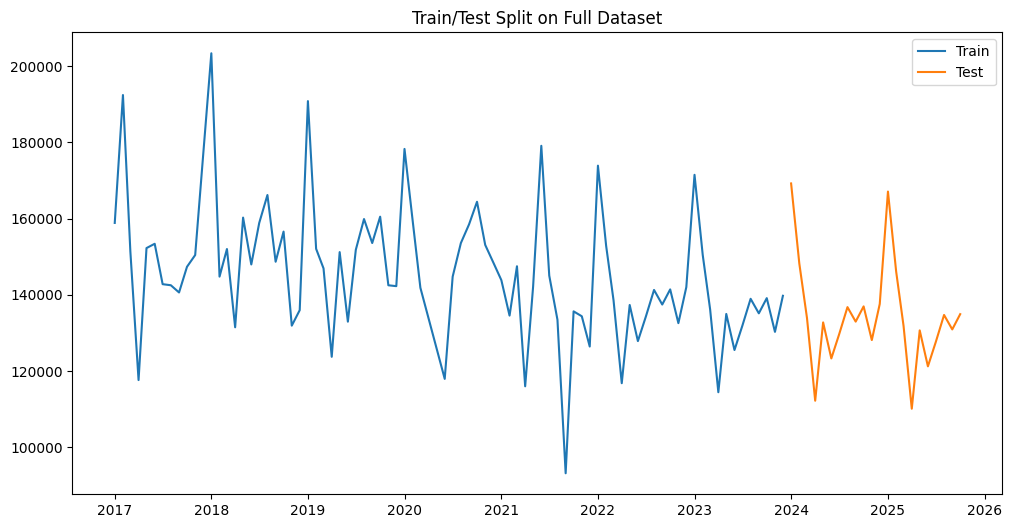

In [8]:
# Train/Test Split
print("\n--- 3. Train/Test Split ---")

split_date = '2024-01-01'
train = df_model[df_model.index < split_date]
test = df_model[df_model.index >= split_date]

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Calls'], label='Train')
plt.plot(test.index, test['Calls'], label='Test')
plt.title('Train/Test Split on Full Dataset')
plt.legend()
plt.savefig('adjusted_split_plot.png')

# Save for next phase
df_model.to_csv('ready_for_modeling.csv')

In [ ]:
#  MODEL: SARIMA 
print("Training SARIMA Baseline...")
sarima_model = SARIMAX(train['Calls'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
sarima_pred = sarima_fit.get_forecast(steps=len(test))
prediction = sarima_pred.predicted_mean

# Evaluate
mape = mean_absolute_percentage_error(test['Calls'], prediction)
rmse = np.sqrt(mean_squared_error(test['Calls'], prediction))

print(f"SARIMA Baseline Metrics:")
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")
print(f"RMSE: {rmse:.4f}")

Training SARIMA Baseline...
SARIMA Baseline Metrics:
MAPE: 0.0354 (3.54%)
RMSE: 5315.9285


In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Calls'], label='Training Data (2016-2023)', color='gray')
plt.plot(test_data.index, test_data['Calls'], label='Actual Future (2024-2025)', color='black')
plt.plot(test_data.index, prediction, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('SARIMA Model Forecast vs Actuals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('sarima_baseline.png')